# Walkthrough

This notebook follows an example project from start to finish. We take video of micron-sized particles diffusing in water, track them, and analyze the trajectories to obtain the viscosity of water.

At the bottom of the notebook, we very briefly survey the more advanced features of trackpy. Browse the [full list of example notebooks](http://nbviewer.ipython.org/github/soft-matter/trackpy-examples/tree/master/notebooks/) to learn more.

## Scientific IPython Setup

We need Python's plotting library, matplotlib. Your environment might load matplotlib automatically, but for this tutorial I'll load it explicitly using this convention. If you are unfamiliar with matplotlib, do the same as I do here, and everything that follows will work without modification.

In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

We also might want to use scientific Python libraries. Finally, we'll import ``trackpy`` itself and its sister project, `pims`.

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

We use the alias ``tp`` for brevity.

## Step 1: Read the Data

### Opening images or video

To get our data into Python, we use our sister project, [PIMS](https://github.com/soft-matter/pims) (Python Image Sequence). PIMS makes is easy and convenient to load and process video data from many formats with one consistent interface.

You can read in:
* a directory or zipfile of sequential images using ``ImageSequence``
* a multi-frame TIFF file using ``TiffStack``
* a video (AVI, MOV, etc.) using ``Video``
* specialty formats used in microscopy and scientific video capture:
    * `Cine`
    * `LSM`
    * Files supported by [Bioformats](https://www.openmicroscopy.org/site/support/bio-formats5.1/supported-formats.html)
    * `ND2` using [PIMS_ND2](https://github.com/soft-matter/pims_nd2)
    

``ImageSequence`` works out of the box, so we recommended trying that to start. The others require some extra dependencies. See the README page.

In [3]:
frames = pims.ImageSequence('../sample_data/bulk_water/*.png', as_grey=True)

In [4]:
frames

<Frames>
Source: /media/d/Casper/code/trackpy-examples/sample_data/bulk_water/*.png
Length: 300 frames
Frame Shape: (424, 640, 4)
Pixel Datatype: uint8

We can access any frame like `frames[frame_number]`. The image is represented as a numpy array of intensities.

In [5]:
print(frames[0])  # the first frame

[[124 124 124 ..., 119 120 121]
 [124 124 124 ..., 119 121 121]
 [124 124 123 ..., 120 122 123]
 ..., 
 [125 126 125 ..., 107  97  96]
 [125 125 124 ..., 115 108 105]
 [125 125 124 ..., 123 118 116]]


In an IPython notebook, the frame is represented by displaying the image.

Frame([[124, 124, 124, ..., 119, 120, 121],
       [124, 124, 124, ..., 119, 121, 121],
       [124, 124, 123, ..., 120, 122, 123],
       ..., 
       [125, 126, 125, ..., 107,  97,  96],
       [125, 125, 124, ..., 115, 108, 105],
       [125, 125, 124, ..., 123, 118, 116]], dtype=uint8)
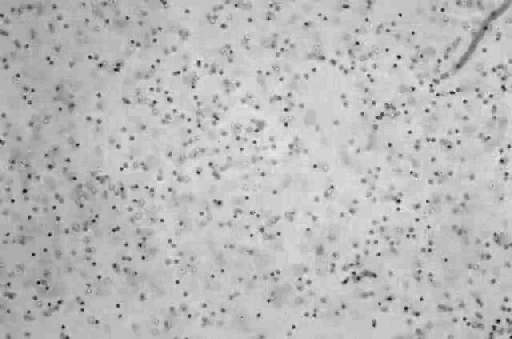

In [6]:
frames[0]

Alternatively, to make a proper plot with axes and control over scaling, use matplotlib.

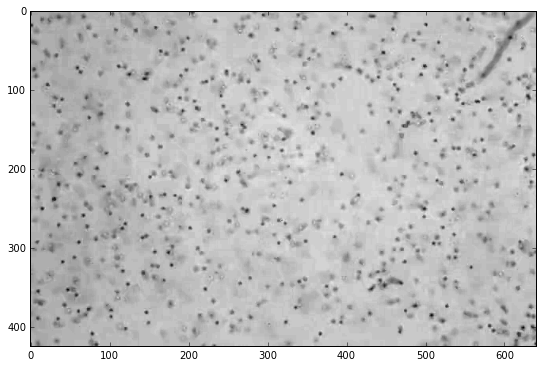

In [7]:
plt.imshow(frames[0]);

Frames behave like numpy arrays with a few extra properties.

In [8]:
frames[123].frame_no

123

In [9]:
frames[123].metadata  # Scientific formats can pass experiment meta data here.

{}

## Step 2: Locate Features

Start with just the first frame. Estimate the size of the features (in pixels). The size must be an odd integer, and it is better to err on the large side, as we'll see below. I estimate 11 pixels.

In [10]:
f = tp.locate(frames[0], 11, invert=True)

The algorithm looks for *bright* features; since my features are dark, I set ``invert=True``.

``locate`` returns a spreadsheet-like object called a DataFrame. It lists 

* each feature's position,
* various characterizations of its appearance, which we will use to filter out spurious features,
* the "signal" strength and an estimate of uncertainty, both derived from this paper

You can read more about DataFrames in the [pandas documentation](pandas.pydata.org/pandas-docs/stable/). They can easily be exported to formats like CSV, Excel, SQL, HDF5, etc.

In [11]:
f.head() # shows the first few rows of data

,x,y,mass,size,ecc,signal,raw_mass,ep,frame
0,295.169679,5.570003,370.325257,2.603612,0.173248,17.881905,10747.0,0.085104,0
1,309.726263,6.895020,278.817856,3.338376,0.061149,5.494440,10536.0,0.135170,0
2,36.036426,8.142955,436.058739,2.927963,0.116840,12.587263,11232.0,0.045968,0
3,67.139323,7.699976,415.879159,2.819623,0.026448,13.885948,11018.0,0.057669,0
4,273.885108,8.546051,319.976207,2.989888,0.203911,9.190700,10631.0,0.106864,0


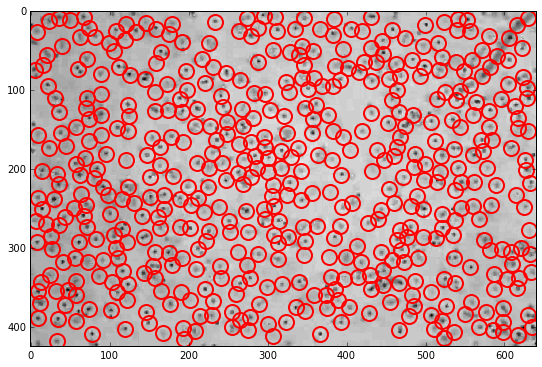

In [12]:
plt.figure()  # make a new figure
tp.annotate(f, frames[0]);

### Refine parameters to elminate spurious features
Many of these circles are clearly wrong; they are fleeting peaks in brightness that aren't actually particles. There are many ways to distinguish real particles from spurrious ones. The most important way is to look at total brightness ("mass").

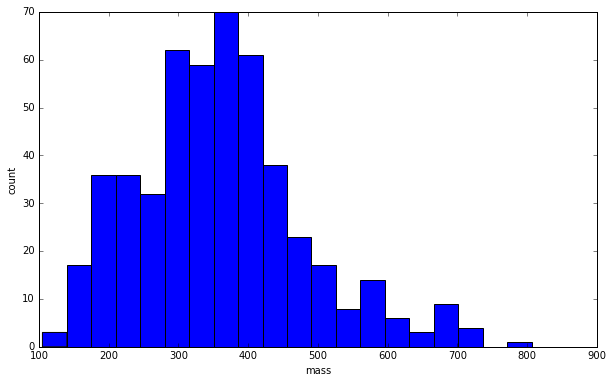

In [13]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [14]:
f = tp.locate(frames[0], 11, invert=True, minmass=200)

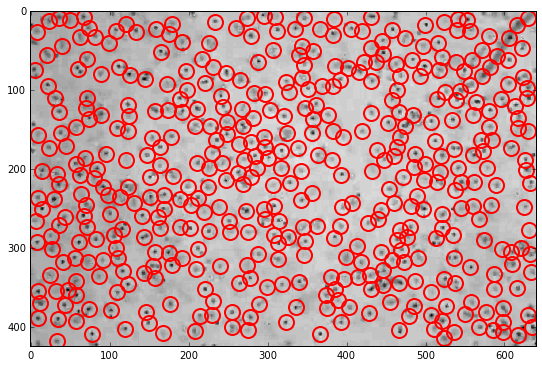

In [15]:
plt.figure()
tp.annotate(f, frames[0]);

There are more options for controling and optimizing feature-finding. You can review them in the [documentation](https://soft-matter.github.io/trackpy/stable/generated/trackpy.feature.html). Or, pull them up as you work by typing ``tp.locate?`` into IPython.

### Check for subpixel accuracy
As Eric Weeks points out in his related tutorial, a quick way to check for subpixel accuracy is to check that the decimal part of the x and/or y positions are evenly distributed. Trackpy provides a convenience plotting function for this:

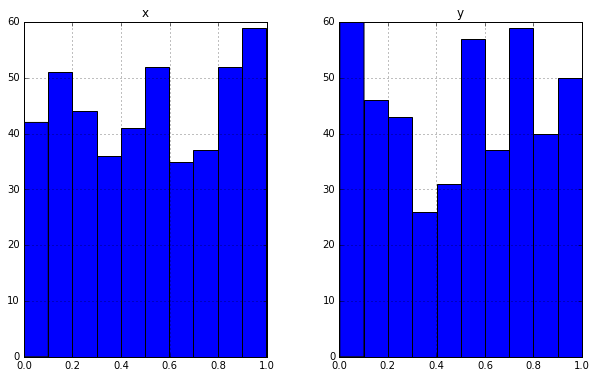

In [16]:
plt.figure()
tp.subpx_bias(f);

If we use a mask size that is too small, the histogram often shows a dip in the middle.

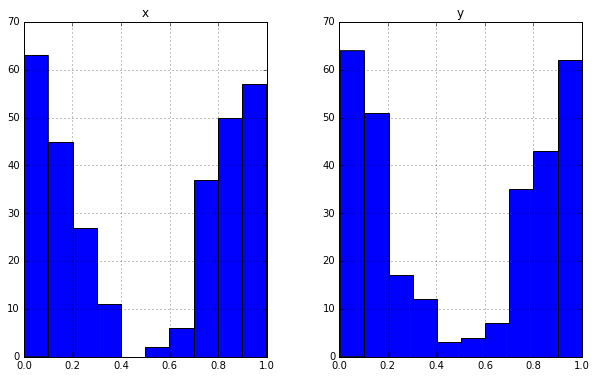

In [17]:
plt.figure()
tp.subpx_bias(tp.locate(frames[0], 7, invert=True, minmass=200));

### Locate features in all frames
Or, to start, just explore a subset of the frames.

 selection | syntax example
 --------- | --------------
 all the frames | `frames[:]` or simply `frames`.
 the first 10 frames | `frames[:10]`
 the last 10 frames | `frames[-10:]`
 a range of frames | `frames[100:200]`
 every 10th frame | `frame[::10]`
 a list of specific frames | `frames[[100, 107, 113]]`

We'll locate features in the first 300 frames from this video. We use ``tp.batch``, which calls ``tp.locate`` on each frame and collects the results.

In [18]:
f = tp.batch(frames[:300], 11, minmass=200, invert=True);

Frame 299: 464 features


As each frame is analyzed, ``tp.batch`` reports the frame number and how many features were found. If this number runs unexpectedly low or high, you may wish to interrupt it and try different parameters.

## Step 3: Link features into particle trajectories
We have the locations of the particles in each frame. Next we'll track particles from frame to frame, giving each one a number for identification.

First, we must must specify a maximum displacement, the farthest a particle can travel between frames. We should choose the smallest reasonable value because a large value slows computation time considerably. In this case, 5 pixels is reasonable.

Second, we allow for the possibility that a particle might be missed for a few frames and then seen again. (Perhaps its "mass" slipped below our cutoff due to noise in the video.) Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance. We'll choose 3.

In [19]:
t = tp.link_df(f, 5, memory=3)

Frame 299: 464 trajectories present


The result is the features DataFrame ``f`` with an additional column, ``particle``, identifying each feature with a label.

In [20]:
t.head()

,x,y,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,295.169679,5.570003,370.325257,2.603612,0.173248,17.881905,10747.0,0.085104,0,0.0
1,295.360118,5.316313,388.202575,2.524643,0.214783,18.883275,10786.0,0.078429,1,0.0
2,296.328125,5.666915,409.267732,2.705631,0.211014,17.458842,10758.0,0.081641,2,0.0
3,296.086566,5.877483,427.689835,2.762346,0.220173,18.511646,10795.0,0.075062,3,0.0
4,296.030423,5.831746,408.020517,2.700627,0.237672,18.458071,10778.0,0.077550,4,0.0


### Filter spurious trajectories.

We have more filtering to do. Empheremeral trajectories -- seen only for a few frames -- are usually spurious and never useful. The convenience function ``filter_stubs`` keeps only trajectories that last for a given number of frames.

In [21]:
t1 = tp.filter_stubs(t, 50)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 4102
After: 834


We can also filter trajectories by their appearance. At this stage, with trajectories linked, we can look at a feature's "average appearance" throughout its trajectory, giving a more accurate picture.

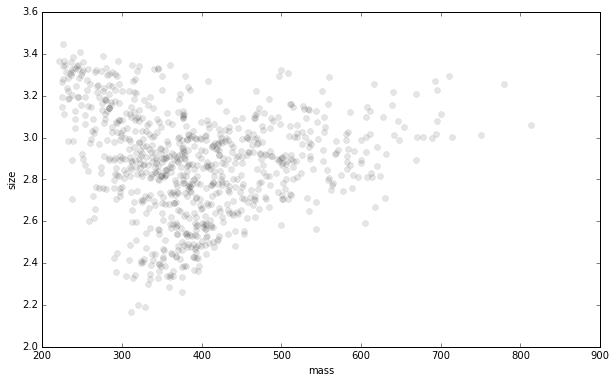

In [22]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

The particles with especially low mass or especially large size are probably out of focus or aggregated, respectively. It is best to experiment by trial and error, filtering out regions of mass-size space and looking at the results using ``tp.annotate`` and ``tp.circle``. In the end, we need to separate the good particles from the spurious ones, and it doesn't matter how we get it done.

In [23]:
t2 = t1[((t1['mass'] > 250) & (t1['size'] < 3.0) &
         (t1['ecc'] < 0.1))]

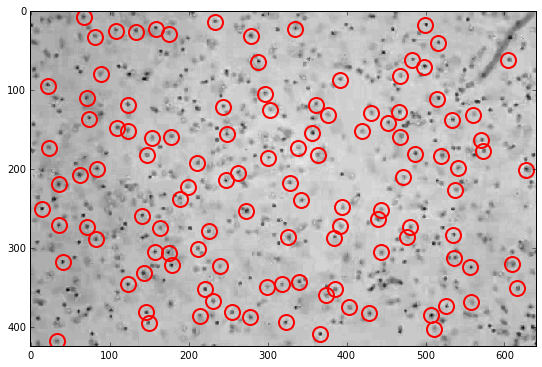

In [24]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0]);

Trace the trajectories.

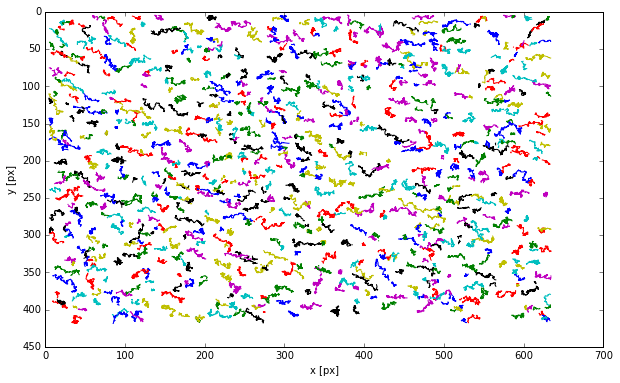

In [25]:
plt.figure()
tp.plot_traj(t1);

### Remove overall drift

Compute the overall drifting motion, which we will subtract away, adopting the reference frame of the particles' average position.

In [26]:
d = tp.compute_drift(t1)

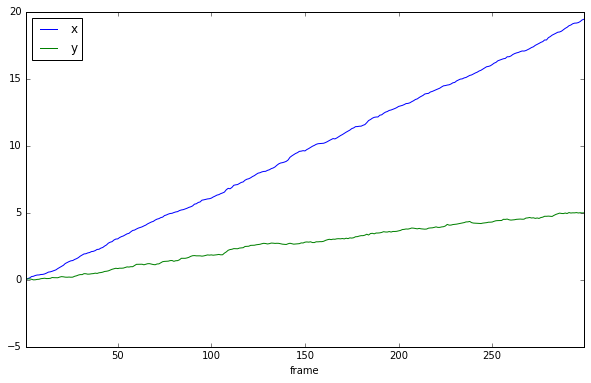

In [27]:
plt.figure()
d.plot();

In [28]:
tm = tp.subtract_drift(t1.copy(), d)

With the overall drifting motion subtracted out, we plot the trajectories again. We observe nice random walks.

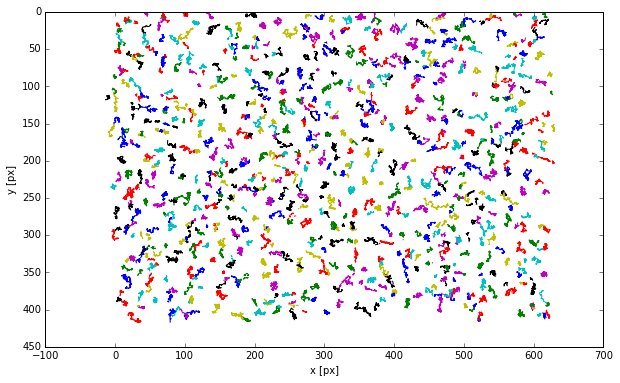

In [29]:
plt.figure()
ax = tp.plot_traj(tm)

## Step 4: Analyze trajectories

### Mean Squared Displacement of Individal Probes

Compute the mean squared displacement of each particle and plot MSD vs. lag time.

In [30]:
im = tp.imsd(tm, 100/285., 24)  # microns per pixel = 100/285., frames per second = 24

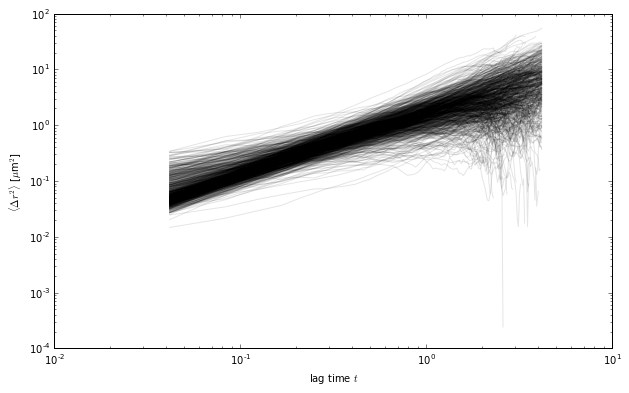

In [31]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

Since we only analyzed 300 frames, the statistics are poor at large lag times. With more frames, we can study larger lag times.

### Ensemble Mean Squared Displacement

In [32]:
em = tp.emsd(tm, 100/285., 24)

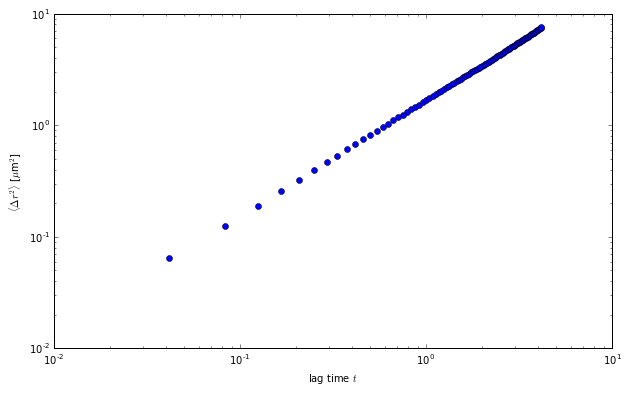

In [33]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10));

We can easily fit this ensemble mean-squared displacement to a power law, $At^n$, using a convenience function, ``fit_powerlaw``, that performs a linear regression in log space.

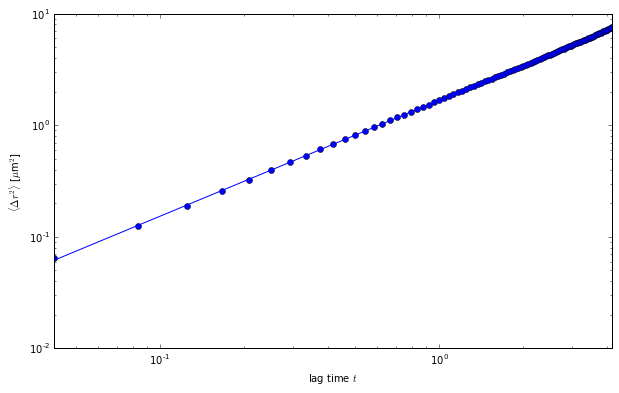

,n,A
msd,1.038835,1.676991


In [34]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots

In water, a viscous material, the expected power-law exponent $n = 1$. The value of $A = 4D$, where $D$ is the particles' diffusivity. $D$ is related to viscosity $\eta$, particle radius $a$, and temperature $T$ as

$D = \displaystyle\frac{kT}{6\pi\eta a}$.

For particles with a 1 $\mu\text{m}$ diameter in room-temperature water, $A \approx 1.66$. Our value above is not far off.

**This is the end of the walkthrough. Keep reading to review the more advanced capabilities in trackpy.**

## Preview of Advanced Features

These are covered in greater detail in later tutorials.

## Streaming

The feature-finding and trajectory-linking functions `batch` and `link_df` keep all of their results in memory. This approach is simple, but it isn't necessary. We can prcoess an unlimited number of frames if we save the results as we go.

Trackpy includes a class to manage storing an retrieving data framewise in an HDF5 format. The general idea is easily extensive to other formats.

In [35]:
with tp.PandasHDFStore('data.h5') as s:
    tp.batch(frames, 11, invert=True, minmass=200, output=s)

Frame 299: 464 features


In [36]:
with tp.PandasHDFStore('data.h5') as s:
    for linked in tp.link_df_iter(s, 5, memory=3):
        s.put(linked)

Frame 299: 464 trajectories present


You can get results by frame with `s.get(frame_number)` or, when you have sufficient memory, retrieve them all. The results is identifical to what you would obtained using the basic functions `batch` and `link_df`.

In [37]:
with tp.PandasHDFStore('data.h5') as s:
    trajectories = pd.concat(iter(s))

## Optional High Performance Component: Numba

The core, time-consuming steps in particle location and linking are implemented in Python/numpy and also in pure Python optimized for numba. If numba is installed, trackpy will detect it and use it by default. You can switch it on and off to compare performance.

In [38]:
%timeit tp.batch(frames[:10], 11, invert=True, minmass=200, engine='numba')

Frame 9: 473 features
1 loop, best of 3: 781 ms per loop


In [39]:
%timeit tp.batch(frames[:10], 11, invert=True, minmass=200, engine='python')

Frame 9: 473 features
1 loop, best of 3: 1.81 s per loop


The linking functions `link_df` or `link_df_iter` support various options for `link_strategy`, one of which is numba-based. Read the their docstrings for details.

## Parallelization
Feature-finding can easily be parallelized: each frame an independent task, and the tasks can be divided among the available CPUs. IPython parallel makes this very straightforward. Please consult the [parallelization tutorial](http://nbviewer.ipython.org/github/soft-matter/trackpy-examples/blob/master/notebooks/parallel-locate.ipynb) for an example of parallelized feature-finding